<a href="https://colab.research.google.com/github/veapasichnyk/Random-Forest-Classifier-Codveda-Internship/blob/main/Build_a_Random_Forest_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Build a Random Forest Classifier

###Import Required Libraries

In [14]:
import pandas as pd
import numpy as np
import importlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import preprocessing_churn
importlib.reload(preprocessing_churn)

from preprocessing_churn import preprocess_churn_data_split

###Load data

In [3]:
df1 = pd.read_csv('churn-bigml-20.csv')
df2 = pd.read_csv('churn-bigml-80.csv')

In [4]:
df_combined = pd.concat([df1, df2], ignore_index=True)

In [5]:
df_combined.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [6]:
print(df_combined.shape)
print(df_combined.info())
print(df_combined.describe())

(3333, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 

In [7]:
# Check for missing values
missing = df_combined.isnull().sum()
print(missing[missing > 0])  # If any


Series([], dtype: int64)


In [8]:
corr = (
    df_combined.assign(Churn=df_combined['Churn'].astype(int))  # make target numeric
              .select_dtypes(include=[np.number])               # keep numeric cols only
              .corr()['Churn']
              .sort_values(ascending=False)
)
print(corr)

Churn                     1.000000
Customer service calls    0.208750
Total day minutes         0.205151
Total day charge          0.205151
Total eve minutes         0.092796
Total eve charge          0.092786
Total intl charge         0.068259
Total intl minutes        0.068239
Total night charge        0.035496
Total night minutes       0.035493
Total day calls           0.018459
Account length            0.016541
Total eve calls           0.009233
Area code                 0.006174
Total night calls         0.006141
Total intl calls         -0.052844
Number vmail messages    -0.089728
Name: Churn, dtype: float64


###Preprocessing data

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test, feature_names = preprocess_churn_data_split(
    df_combined, scaler_numeric=False
)

###Random Forest Model

In [13]:
#Train Random Forest with hyperparameter tuning using GridSearchCV
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
grid = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [15]:
#Evaluate the model on the validation set
y_val_pred = best_rf.predict(X_val)
print("Validation F1:", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation F1: 0.7529411764705882
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       570
           1       0.88      0.66      0.75        97

    accuracy                           0.94       667
   macro avg       0.91      0.82      0.86       667
weighted avg       0.93      0.94      0.93       667



In [16]:
#Final evaluation on TEST (held-out)
y_test_pred = best_rf.predict(X_test)
print("Test F1:", f1_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Test F1: 0.7674418604651163
Accuracy: 0.9400299850074962
Confusion Matrix:
 [[561   9]
 [ 31  66]]


**Model Performance**

1. Accuracy = 94%

Out of all customers, 94% were classified correctly.

2. F1 Score (for churn class) = 0.77

This balances precision and recall for the minority churn class.

It means the model is reasonably good at identifying churn customers without over-predicting them.

3. Confusion Matrix:

[[561   9]   → True Negatives = 561, False Positives = 9

 [ 31  66]]  → False Negatives = 31, True Positives = 66


The model correctly predicts 66 churners and 561 non-churners.

It misses 31 churners (false negatives) and wrongly flags 9 non-churners as churn (false positives).

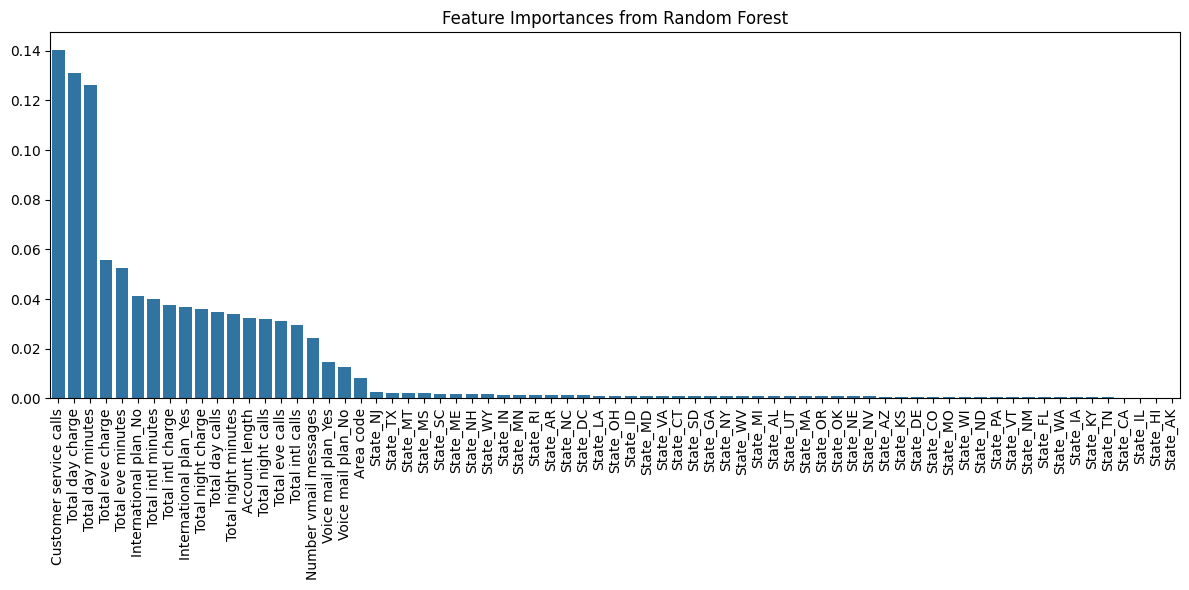

In [17]:
#Feature importance visualization
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=np.array(feature_names)[indices], y=importances[indices])
plt.xticks(rotation=90)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

**Key Insights**

1. Top drivers of churn

- `Customer service calls` → The strongest predictor (0.14).
Suggests that customers who contact support often are more likely to churn (frustration/unresolved issues).

- `Total day minutes / charge` → High daytime usage may signal important customers, but also those sensitive to costs.

- `International plan (Yes/No)` → Very strong impact, probably because international plan users either generate more revenue or are more prone to churn if dissatisfied.

- `Evening usage (minutes/charge)` → Also moderately important.

2. Less relevant features

- `States` contribute almost nothing — makes sense, churn is more about behavior than location.

- `Area code` similarly uninformative.

- `Voice mail plan` has limited impact compared to international plan and call activity.

📊 Recommendations (based on top features)

- Improve Customer Service: Reduce the number of repeated support calls by investing in faster resolution. Each unresolved call correlates with churn.

- Pricing & Usage:

Review daytime charges for heavy users — loyalty discounts or bundles could retain them.

International plan customers may need more personalized retention offers (e.g., cheaper international minutes).

- De-prioritize location-based features: State/area code should probably be dropped or grouped — they add complexity but little predictive value.